## Objective: Predictive model to identify orders that will be returned and provide suggestions to reduce the return rate

## Overview: Built classification models using multiple algorithms to predict order returns. The notebook is divided into 2 major parts as follows - 
### Part 1: Classification models without over/undersampling techniques
### Part 2: SMOTE Random forest and Logistic regression classification model i.e. with over-sampling technique
##### Note: Oversampling is considered due to highly imbalance class distribution 

### Table of content:
#### 1. Data encoding and wrangling
#### 2. Target variable distribution
#### 3. Feature selection
#### 4. Part 1: Classification models without oversampling techniques & model performance metrics
##### 4.1. Logistic regression, KNN, Decision Tree & Random forest
#### 5. Part 2: Classification model with over-sampling techniques & model performance metrics
##### 5.1. SMOTE Random foreset, SMOTE Logistic regression
#### 6. SHAP values & partial dependence plots for model evaluation

In [34]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import plotly.express as px
from mlxtend.preprocessing import minmax_scaling

import plotly.graph_objects as go
#import plotly.subplots as sp
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant

from IPython.display import HTML, display, Markdown, clear_output

from scipy.stats import f_oneway

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

from statistics import mean
from sklearn import metrics
import matplotlib.pyplot as plt
 
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import tree

from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
import seaborn as sns

from sklearn.inspection import PartialDependenceDisplay

%matplotlib inline

In [35]:
df=pd.read_csv('CaseStudy_Returns_Superstore_v5.csv')
superstore=df.copy()
superstore = superstore.rename(columns=lambda s: s.replace(".", "_"))
superstore

,Row_ID,Order_ID,Customer_Name,Order_Date,Order_Priority,Order_Quantity,Sales,Discount,Ship_Mode,Profit,Unit_Price,Shipping_Cost,Region,Customer_Segment,Product_Category,Product_Container,Product_Base_Margin,Ship_Date,Return_Status,date_diff
0,1,3,Muhammed MacIntyre,13-10-2010,Low,6,261.5400,0.04,Regular Air,-213.25,38.94,35.00,Nunavut,Small Business,Office Supplies,Large Box,0.80,20-10-2010,0,7
1,2,293,Barry French,01-10-2012,High,49,10123.0200,0.07,Delivery Truck,457.81,208.16,68.02,Nunavut,Consumer,Office Supplies,Jumbo Drum,0.58,02-10-2012,0,1
2,3,483,Clay Rozendal,10-07-2011,High,30,4965.7595,0.08,Regular Air,1198.97,195.99,3.99,Nunavut,Corporate,Technology,Small Box,0.58,12-07-2011,0,2
3,4,515,Carlos Soltero,28-08-2010,Not Specified,19,394.2700,0.08,Regular Air,30.94,21.78,5.94,Nunavut,Consumer,Office Supplies,Medium Box,0.50,30-08-2010,0,2
4,5,613,Carl Jackson,17-06-2011,High,12,93.5400,0.03,Regular Air,-54.04,7.30,7.72,Nunavut,Corporate,Office Supplies,Small Box,0.38,17-06-2011,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,5492,47360,Frank Hawley,08-10-2010,Not Specified,25,2200.6400,0.05,Delivery Truck,-514.18,89.99,42.00,West,Home Office,Furniture,Jumbo Drum,0.66,10-10-2010,0,2
5492,5493,52706,Harry Greene,09-07-2012,Low,34,1041.6600,0.02,Express Air,480.53,28.53,1.49,West,Corporate,Office Supplies,Small Box,0.38,16-07-2012,0,7
5493,5494,54279,Harry Greene,30-07-2011,High,41,10071.0900,0.10,Delivery Truck,1977.69,264.98,17.86,West,Corporate,Technology,Jumbo Drum,0.58,31-07-2011,0,1
5494,5495,55558,Mick Brown,09-08-2010,Medium,8,1294.0400,0.05,Delivery Truck,-323.18,150.98,66.27,West,Consumer,Furniture,Jumbo Box,0.65,09-08-2010,0,0


In [36]:
### Created a "date_diff" column which means [Ship_Date - Order_Date]
### Hypothesis - Orders with higher date diff. gets returned often

### More feature engineering code have been done like - extracting out weekend and weekdays and analysing with return status

### Data encoding and wrangling

In [37]:
superstore=superstore.drop('Row_ID',axis=1)

## List of columns selected for modelling
superstore_mod=superstore[['Order_Priority',
       'Order_Quantity', 'Sales', 'Discount', 'Ship_Mode',
       'Unit_Price', 'Shipping_Cost', 'Region', 'Customer_Segment',
       'Product_Category', 'Product_Container',
       'Return_Status']]

## List of columns for dummy/one-hot encoding
superstore_mod_cat_dumm=superstore_mod[['Ship_Mode','Region','Customer_Segment','Product_Category','Product_Container']]

## List of column(s) for label encoding
superstore_mod_cat_lab=superstore_mod[['Order_Priority']]

## List of numerical columns for scaling 
superstore_mod_num=superstore_mod[['Order_Quantity', 'Sales', 'Discount', 
       'Unit_Price', 'Shipping_Cost']]

In [38]:
## Performed min-max scaling on the list of numerical columns
superstore_mod_num_minmaxsc=minmax_scaling(superstore_mod_num
                                             , columns=['Order_Quantity', 'Sales', 'Discount',
                                                       'Unit_Price', 'Shipping_Cost'
                                                        ])
## Performed label enconding on Order Priority
def conditions(i): 
    if i == "Low": return 2
    if i == "High": return 5
    if i == "Critical": return 5
    if i == "Medium": return 3
    if i == "Not Specified": return 1

superstore_mod_cat_lab['Order_Priority_lab']=superstore_mod_cat_lab['Order_Priority'].apply(conditions)

## Performed dummy/on-hot encoding on the categorical column list
superstore_mod_cat_dumm_enc=pd.get_dummies(superstore_mod_cat_dumm
                                           ,columns=superstore_mod_cat_dumm.columns
                                           ,drop_first=True)

In [39]:
## Joined dummy encoded - min max scaled - label encoded dataset and created a the final encoded modelling dataset

superstore_enc_dumm_lab=pd.merge(superstore_mod_cat_dumm_enc,superstore_mod_cat_lab,left_index=True,right_index=True)
superstore_enc_dumm_lab=superstore_enc_dumm_lab.drop('Order_Priority',axis=1)
superstore_enc_cols=pd.merge(superstore_enc_dumm_lab,
                       superstore_mod_num_minmaxsc,
                       left_index=True,right_index=True)

superstore_y=superstore[['Return_Status']]

superstore_enc_cols_y=pd.merge(superstore_enc_cols,
                       superstore_y,
                       left_index=True,right_index=True)
superstore_enc_cols_y

,Ship_Mode_Express Air,Ship_Mode_Regular Air,Region_Northwest Territories,Region_Nunavut,Region_Ontario,Region_Prarie,Region_Quebec,Region_West,Region_Yukon,Customer_Segment_Corporate,...,Product_Container_Small Box,Product_Container_Small Pack,Product_Container_Wrap Bag,Order_Priority_lab,Order_Quantity,Sales,Discount,Unit_Price,Shipping_Cost,Return_Status
0,0,1,0,1,0,0,0,0,0,0,...,0,0,0,2,0.102041,0.002900,0.235294,0.005596,0.210119,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,5,0.979592,0.113632,0.411765,0.030547,0.411167,0
2,0,1,0,1,0,0,0,0,0,1,...,1,0,0,5,0.591837,0.055723,0.470588,0.028752,0.021310,0
3,0,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0.367347,0.004391,0.470588,0.003065,0.033183,0
4,0,1,0,1,0,0,0,0,0,1,...,1,0,0,5,0.224490,0.001014,0.176471,0.000930,0.044021,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5491,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0.489796,0.024674,0.294118,0.013123,0.252740,0
5492,1,0,0,0,0,0,0,1,0,1,...,1,0,0,2,0.673469,0.011660,0.117647,0.004061,0.006089,0
5493,0,0,0,0,0,0,0,1,0,1,...,0,0,0,5,0.816327,0.113049,0.588235,0.038925,0.105760,0
5494,0,0,0,0,0,0,0,1,0,0,...,0,0,0,3,0.142857,0.014494,0.294118,0.022116,0.400511,0


## Target variable distribution
#### Observation - Imbalance class distribution 
##### Note : Applied classification models without oversampling (Part 1) & Performed over sampling and implemented SMOTE RF model (Part 2)

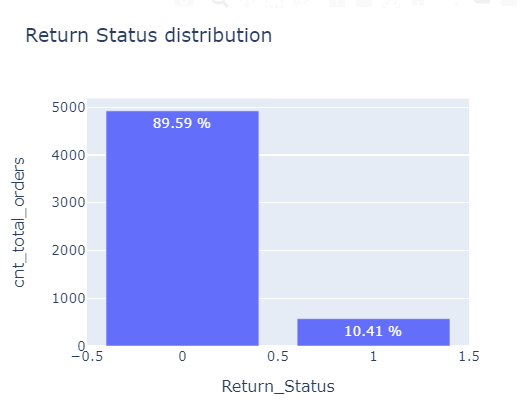

### Train test split and Target variable selection

In [40]:
## Target variable selection and split % 
target_var='Return_Status'
split_percentage=20

In [41]:
## X and y seperation
split_perc=split_percentage/100
X=superstore_enc_cols_y.loc[:,superstore_enc_cols_y.columns]
y=superstore_enc_cols_y[target_var]
X=X.drop(target_var,axis=1)

In [42]:
## Splitting the data for modelling (without oversampling)
x_train,x_valid,y_train,y_valid=train_test_split(X,y,test_size=split_perc,random_state=0)

print("Training-Validation Split Percentage:{split}".format(split=int((1-split_perc)*100)))
print("Total Observation:{obs}".format(obs=X.shape[0]))
print("Training Observation:{train_obs}".format(train_obs=x_train.shape[0]))
print("Validation Observation:{valid_obs}".format(valid_obs=x_valid.shape[0]))

Training-Validation Split Percentage:80
Total Observation:5496
Training Observation:4396
Validation Observation:1100


### Feature selection
#### Multi colinearity check

In [43]:
def multi_collinear(x_train_processed):
    truncate_value=15
    exog_df=x_train_processed.loc[:,x_train_processed.columns!=target_var]
    exog_df=x_train_processed.copy()
    
    exog_df=add_constant(exog_df)
    vifs=pd.Series([1/(1.-OLS(exog_df[col].values,
                              exog_df.loc[:,exog_df.columns!=col].values).fit().rsquared) for col in exog_df],
                   index=exog_df.columns,
                   name='VIF')
    
    vifs=pd.DataFrame(vifs)
    vifs.drop('const',axis=0,inplace=True)
    vifs=vifs['VIF'].where(vifs['VIF']<=truncate_value,truncate_value)
    vifs=pd.DataFrame(vifs)
    vifs_df=vifs.sort_values(by=['VIF'],ascending=True)
    
    vifs_df['colors']=np.where(vifs_df.VIF<=5,'yellowgreen',
                                 np.where((vifs_df.VIF>5) & (vifs_df.VIF<=10),'steelblue','tomato'))
    
    Layout=go.Layout(title="VIF plot", xaxis=dict(title='VIF'),yaxis=dict(title='Features'))
    fig=go.Figure(go.Bar(x=vifs_df.VIF,y=vifs_df.index.tolist(),
                         orientation='h',marker_color=vifs_df['colors']),layout=Layout)
    fig.add_shape(type="line",x0=5,y0=0,x1=5,y1=len(vifs_df.index.tolist()),
                  line=dict(color="midnightblue",width=2,dash="dot"))
    fig.add_shape(type="line",x0=10,y0=0,x1=10,y1=len(vifs_df.index.tolist()),
                  line=dict(color="midnightblue",width=2,dash="dot"))
    
    fig.update_layout(width=800,height=800)
    fig.show(config={'displaylogo':False})
    return vifs

vifs=multi_collinear(x_train)


def multi_col_vars(vifs):
    multicorr_vars=vifs['VIF'].loc[lambda x:x>=10].index.tolist()
    col_to_drop=multicorr_vars
    
    if col_to_drop==[]:
        #clear_output()
        print("No columns were dropped")
    else:
        #clear_output()
        x_train.drop(col_to_drop,axis=1,inplace=True)
        display(Markdown('Successfully dropped:{}'.format(",".join(col_to_drop))))
        
        display(x_train.dtypes)
    return x_train


x_train=multi_col_vars(vifs)

Successfully dropped:Ship_Mode_Express Air,Ship_Mode_Regular Air,Product_Container_Large Box,Product_Container_Medium Box,Product_Container_Small Box,Product_Container_Small Pack,Product_Container_Wrap Bag

Region_Northwest Territories          uint8
Region_Nunavut                        uint8
Region_Ontario                        uint8
Region_Prarie                         uint8
Region_Quebec                         uint8
Region_West                           uint8
Region_Yukon                          uint8
Customer_Segment_Corporate            uint8
Customer_Segment_Home Office          uint8
Customer_Segment_Small Business       uint8
Product_Category_Office Supplies      uint8
Product_Category_Technology           uint8
Product_Container_Jumbo Drum          uint8
Order_Priority_lab                    int64
Order_Quantity                      float64
Sales                               float64
Discount                            float64
Unit_Price                          float64
Shipping_Cost                       float64
dtype: object

In [44]:
## Chceking variability between the column values
def variability(x_train):
    selected_features=[]
    selected_features_dict={}
    col_drop=[]
    zero_variance=(x_train.describe().loc['std']==0)
    zero_variance=zero_variance[zero_variance].index.tolist()
    if len(zero_variance)==0:
        print('No columns with 0 std dev.')
    else:
        display(pd.DataFrame(zero_varinace,columns=['Features']))
        col_drop.extend(zero_variance)
    return selected_features,selected_features_dict,col_drop

variability(x_train)

No columns with 0 std dev.


([], {}, [])

In [45]:
## Filtering the list of columns in the x_test dataframe as per the x_train VIF removed columns
x_test=[]
for i in x_train:
    if i in x_valid:
        x_test.append(i)
        
x_test=x_valid[x_test]
#x_test

#### Feature importance check using Random foreset and Logistic regression models

Text(0.5, 1.0, 'Random Forest imp.')

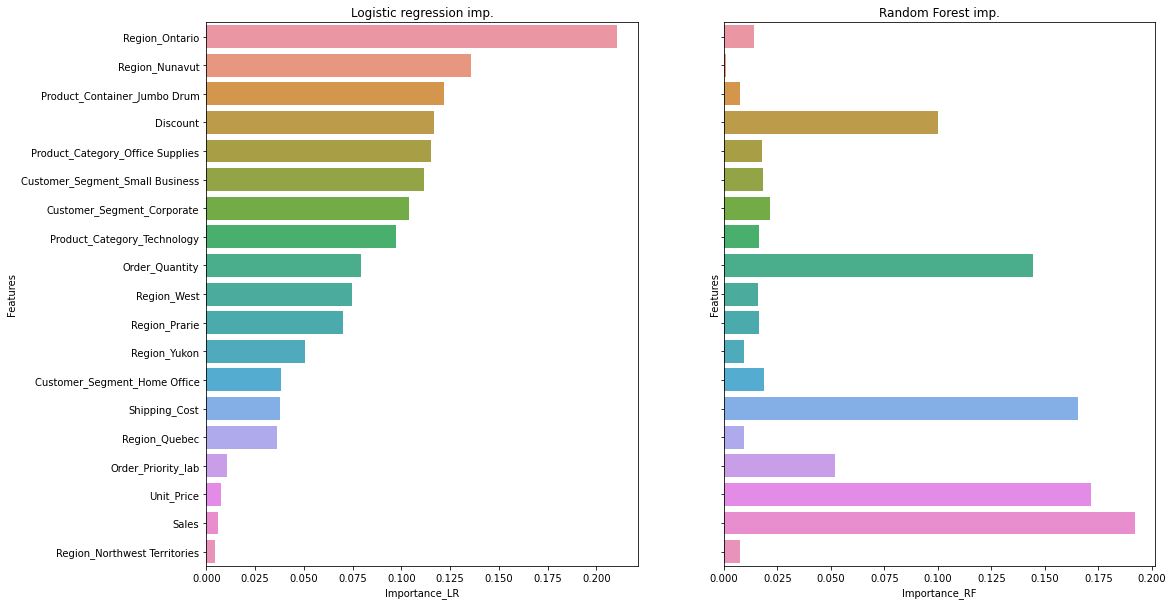

In [46]:
## Checking the "m" value of the features using random forest baseline model 
forest = RandomForestClassifier()
forest.fit(x_train, y_train)
    
importances=forest.feature_importances_
importances=importances.tolist()

feat_labels= x_train.columns[:]
feat_labels=feat_labels.tolist()

df_imp_rf=pd.DataFrame({'Features':feat_labels,'Importance_RF':importances}).sort_values('Importance_RF', ascending=False)
#df_imp_rf

## Checking the "m" value of the features using Logistic regression model 
LR = LogisticRegression()

LR.fit(x_train / np.std(x_train, 0), y_train)
importanceLR=LR.coef_

importanceLR=importanceLR.tolist()
importanceLR=[item for sublist in importanceLR for item in sublist]
importanceLR=[abs(ele) for ele in importanceLR]

feat_labels=x_train.columns[:]
feat_labels=feat_labels.tolist()

df_imp_LR=pd.DataFrame({'Features':feat_labels,'Importance_LR':importanceLR}).sort_values('Importance_LR', ascending=False)

feature_imp=pd.merge(df_imp_LR,df_imp_rf,how='inner',on='Features')
#feature_imp

fig, axes = plt.subplots(1, 2, figsize=(17, 10), sharey=True)

sns.barplot(ax=axes[0], x=feature_imp['Importance_LR'], y=feature_imp['Features'],orient = 'h')
axes[0].set_title("Logistic regression imp.")

sns.barplot(ax=axes[1], x=feature_imp['Importance_RF'], y=feature_imp['Features'],orient = 'h')
axes[1].set_title("Random Forest imp.")

## No feature filtering was done even if a few feature had very low importance

## Part 1 : ML classification algorithms (without Over Sampling)

### Logistic regression

Accuracy (test dataset) of the logistic regression model: 0.9027272727272727
Accuracy (train dataset) of the logistic regression model: 0.8942220200181984
              precision    recall  f1-score   support

     class 0       0.90      1.00      0.95       993
     class 1       0.00      0.00      0.00       107

    accuracy                           0.90      1100
   macro avg       0.45      0.50      0.47      1100
weighted avg       0.81      0.90      0.86      1100

[[993   0]
 [107   0]]


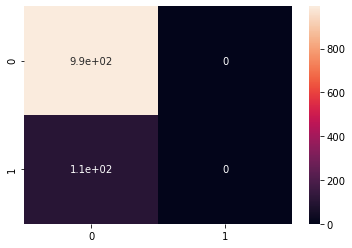

In [47]:
# LR train model
logistic_clf = LogisticRegression(random_state=100).fit(x_train, y_train)
y_pred=logistic_clf.predict(x_test)
print("Accuracy (test dataset) of the logistic regression model:",metrics.accuracy_score(y_valid, y_pred))

y_pred_train=logistic_clf.predict(x_train)
print("Accuracy (train dataset) of the logistic regression model:",metrics.accuracy_score(y_train, y_pred_train))

target_names = ['class 0', 'class 1']
print(classification_report(y_valid, y_pred, target_names=target_names))

#confusion matrix
cf_matrix = confusion_matrix(y_valid, y_pred)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

### KNN

Maximum accuracy:- 0.9036363636363637 at K = 6


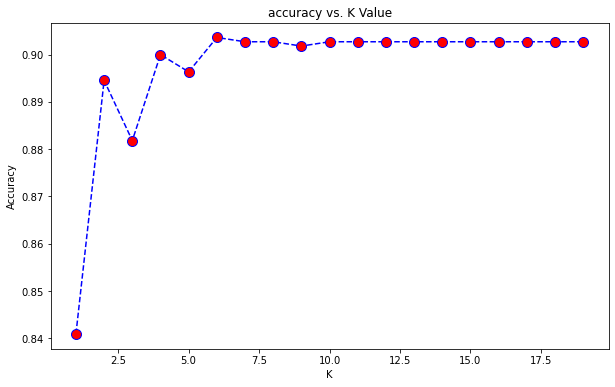

In [48]:
## Finding the optimal K value 
acc = []
for i in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = i).fit(x_train, y_train)
    yhat = neigh.predict(x_test)
    acc.append(metrics.accuracy_score(y_valid, yhat))
    
plt.figure(figsize=(10,6))
plt.plot(range(1,20),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:-",max(acc),"at K =",acc.index(max(acc))+1)

Accuracy (test dataset) of model at K=6 is 0.9036363636363637
Accuracy (train dataset) of model at K=6 is 0.8949044585987261
              precision    recall  f1-score   support

     class 0       0.90      1.00      0.95       993
     class 1       1.00      0.01      0.02       107

    accuracy                           0.90      1100
   macro avg       0.95      0.50      0.48      1100
weighted avg       0.91      0.90      0.86      1100

[[993   0]
 [106   1]]


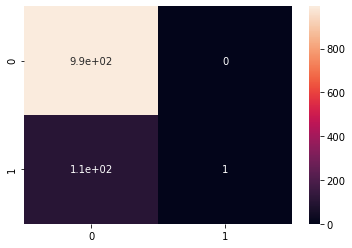

In [49]:
k = 6
neigh = KNeighborsClassifier(n_neighbors = k).fit(x_train, y_train)
Pred_y = neigh.predict(x_test)
print("Accuracy (test dataset) of model at K=6 is",metrics.accuracy_score(y_valid, Pred_y))

Pred_y_train = neigh.predict(x_train)
print("Accuracy (train dataset) of model at K=6 is",metrics.accuracy_score(y_train, Pred_y_train))

target_names = ['class 0', 'class 1']
print(classification_report(y_valid, Pred_y, target_names=target_names))

cf_matrix = confusion_matrix(y_valid, Pred_y)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

#### GridsearchCV implementation for finding best hyperparameters

In [50]:
## Decision tree best hyperparameter set
param_grid_dt = {'max_features': ['auto', 'sqrt', 'log2'],
              'max_depth' : [5, 6, 7, 8, 9],
              'criterion' :['gini', 'entropy']
             }
tree_clas = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator=tree_clas, param_grid=param_grid_dt, verbose=True)
grid_search.fit(x_train, y_train)

final_model_dt = grid_search.best_estimator_
print(final_model_dt)

## Random forest best hyperparameter set
param_grid_rf = { 
    'n_estimators': [5, 10, 20, 30, 50, 100],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc=RandomForestClassifier()
gridsearch_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, n_jobs=4)
gridsearch_rfc.fit(x_train, y_train)

final_model_rfc=gridsearch_rfc.best_params_
print("RF best params:",final_model_rfc)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
DecisionTreeClassifier(max_depth=5, max_features='sqrt')
RF best params: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'auto', 'n_estimators': 10}


### Decision tree classifier

In [51]:
dt_clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=6, max_features='sqrt')
# train decision tree
dt_clf = dt_clf.fit(x_train, y_train)

y_pred = dt_clf.predict(x_test)

print("Accuracy (test dataset) of the DT model:",metrics.accuracy_score(y_valid, y_pred))

y_pred_train = dt_clf.predict(x_train)
print("Accuracy (train dataset) of the DT model:",metrics.accuracy_score(y_train, y_pred_train))

Accuracy (test dataset) of the DT model: 0.9018181818181819
Accuracy (train dataset) of the DT model: 0.8964968152866242


### Random forest classifier

Accuracy (test dataset) of model RF is 0.9027272727272727
Accuracy (train dataset) of model RF is 0.8942220200181984
[[993   0]
 [107   0]]


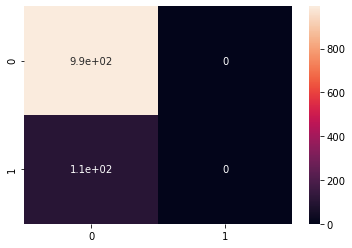

In [52]:
rf_model = RandomForestClassifier(n_estimators=10, criterion='gini', max_depth=4, max_features='auto')
rf_model.fit(x_train, y_train)
predictions = rf_model.predict(x_test)

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(y_valid, predictions))

predictions_train = rf_model.predict(x_train)
print("Accuracy (train dataset) of model RF is",metrics.accuracy_score(y_train, predictions_train))

cf_matrix = confusion_matrix(y_valid, predictions)
print(cf_matrix)
sns.heatmap(cf_matrix, annot=True)

### NOTE : Business won't be able to use/consume any of these above model output/recommendation since the RECALL value is very very low (=0 in most of the cases), which means although the accuracy of the models are good and doesn't overfit (looking into the training and testing accuracies), it is unable to catch 1's i.e. return orders i.e. True positives.

## Part 2 : ML classification algorithm (with Over Sampling)
### Oversampling for class imbalance using SMOTE 

In [53]:
## Since Sampling should be done after VIF treated feature removal 
## Filtering the VIF removed list of columns from X 
X_vif=[]
for i in x_train:
    if i in X:
        X_vif.append(i)
        
X_vif=X[X_vif]
#X_vif

In [54]:
#Using SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X_vif, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=split_perc, stratify=over_y)

#### GridSearchCV for best hyperparametes on oversampled dataset

In [55]:
## RF best hyperparameter set on the oversampled data
param_grid_rf = { 
    'n_estimators': [5, 10, 20, 30, 50, 100, 150],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8,10],
    'criterion' :['gini', 'entropy']
}

rfc=RandomForestClassifier()
gridsearch_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, n_jobs=4)
gridsearch_rfc.fit(over_X_train, over_y_train)

final_model_rfc=gridsearch_rfc.best_params_
final_model_rfc

{'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'n_estimators': 30}

### SMOTE Random forest model

Cross validation mean results
Mean f1: 0.783
Mean recall: 0.880
Mean precision: 0.707
-----------------------
Model fit & predict results
Accuracy (test dataset) of model RF is 0.7036363636363636
Accuracy (train dataset) of model RF is 0.6917652411282984


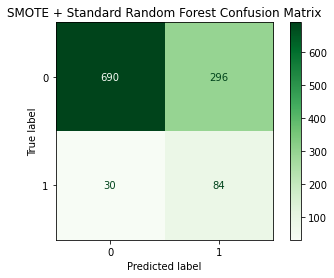

              precision    recall  f1-score   support

     class 0       0.96      0.70      0.81       986
     class 1       0.22      0.74      0.34       114

    accuracy                           0.70      1100
   macro avg       0.59      0.72      0.57      1100
weighted avg       0.88      0.70      0.76      1100



In [62]:
#Building SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=50, criterion='gini', max_depth=10, max_features='sqrt')

#Creating Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=250)
scoring = ('f1', 'recall', 'precision')

#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)

print('Cross validation mean results')
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('-----------------------')
print('Model fit & predict results')

X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=split_perc, stratify=y)

#Training SMOTE RF
SMOTE_SRF.fit(over_X_train, over_y_train)

#SMOTE RF prediction 
y_pred = SMOTE_SRF.predict(X_test)

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(y_test, y_pred))
predictions_train = SMOTE_SRF.predict(X_train)
print("Accuracy (train dataset) of model RF is",metrics.accuracy_score(y_train, predictions_train))

#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_SRF, X_test, y_test, display_labels=[0,1], cmap='Greens')
plt.title('SMOTE + Standard Random Forest Confusion Matrix')
plt.show()

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

### SMOTE Logistic regression model

Cross validation mean results
Mean f1: 0.624
Mean recall: 0.658
Mean precision: 0.594
-----------------------
Model fit & predict results
Accuracy (test dataset) of model RF is 0.5172727272727272
Accuracy (train dataset) of model RF is 0.5618744313011829


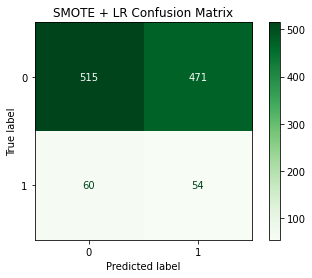

              precision    recall  f1-score   support

     class 0       0.90      0.52      0.66       986
     class 1       0.10      0.47      0.17       114

    accuracy                           0.52      1100
   macro avg       0.50      0.50      0.41      1100
weighted avg       0.81      0.52      0.61      1100



In [59]:
#Building SMOTE LR model
SMOTE_LR = LogisticRegression(random_state=500)

#Creating Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=250)
scoring = ('f1', 'recall', 'precision')

#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_LR, over_X, over_y, scoring=scoring, cv=cv)

print('Cross validation mean results')
print('Mean f1: %.3f' % mean(scores['test_f1']))
print('Mean recall: %.3f' % mean(scores['test_recall']))
print('Mean precision: %.3f' % mean(scores['test_precision']))
print('-----------------------')
print('Model fit & predict results')

X_train, X_test, y_train, y_test = train_test_split(X_vif, y, test_size=split_perc, stratify=y)

#Training SMOTE RF
SMOTE_LR.fit(over_X_train, over_y_train)

#SMOTE RF prediction 
y_pred = SMOTE_LR.predict(X_test)

print("Accuracy (test dataset) of model RF is",metrics.accuracy_score(y_test, y_pred))
predictions_train = SMOTE_LR.predict(X_train)
print("Accuracy (train dataset) of model RF is",metrics.accuracy_score(y_train, predictions_train))

#Create confusion matrix
fig = plot_confusion_matrix(SMOTE_LR, X_test, y_test, display_labels=[0,1], cmap='Greens')
plt.title('SMOTE + LR Confusion Matrix')
plt.show()

target_names = ['class 0', 'class 1']
print(classification_report(y_test, y_pred, target_names=target_names))

### NOTE: Business will be able to use/consume these above models output/recommendation since the RECALL value is good (>50% of the cases), which means although the accuracy of the model is good and doesn't overfit (looking into the training and testing accuracies), it is able to catch 1's i.e. return orders i.e. True positives, thus reducing the risk of return. (also reduce false negatives)

### SHAP values and Partial dependence plot for SMOTE + RF model evaluation

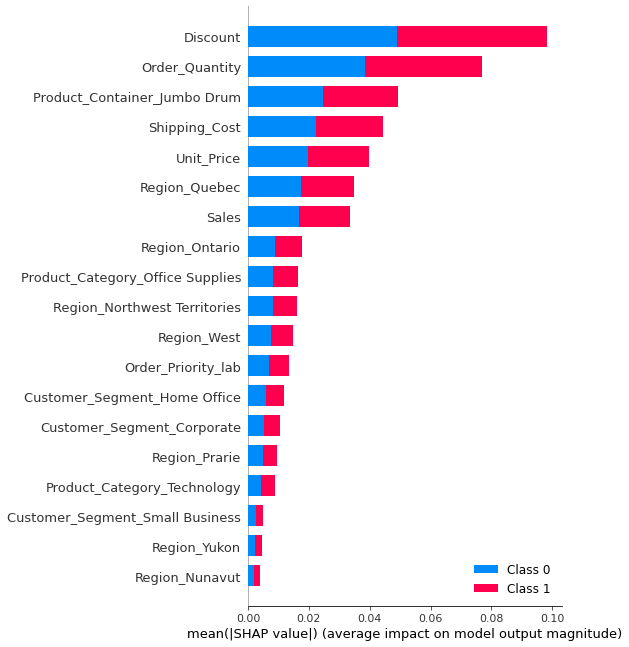

In [60]:
import shap

explainer=shap.TreeExplainer(SMOTE_SRF)
shap_values=explainer.shap_values(X_test)

shap.summary_plot(shap_values,X_test,plot_type="bar")

Computing partial dependence plots...


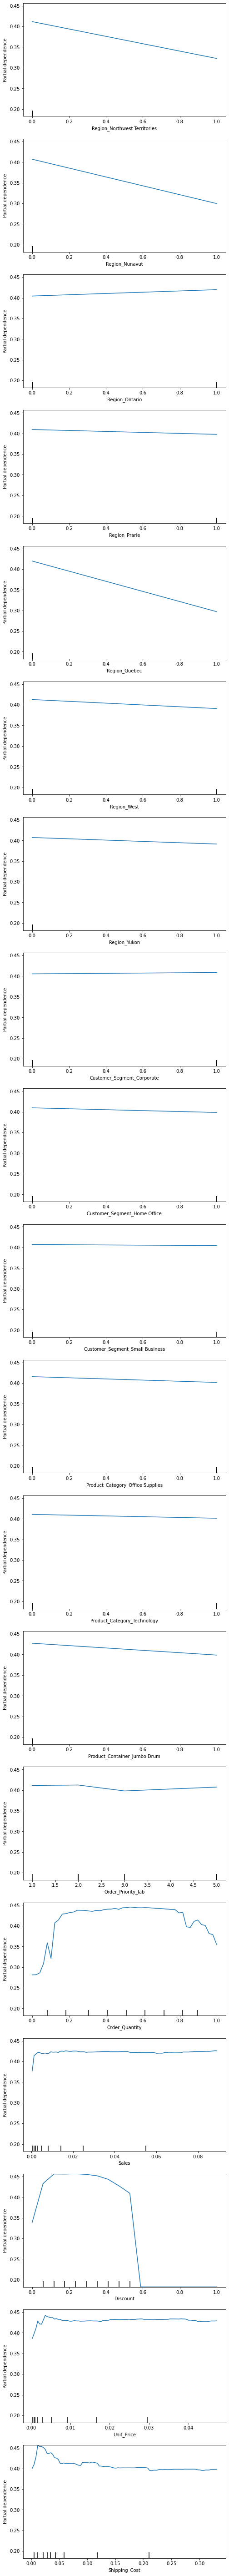

In [61]:
# common_params = {
#     "subsample": 2000,
#     "n_jobs": 2,
#     "grid_resolution": 20,
#     "random_state": 200,
# }

print("Computing partial dependence plots...")
features_info = {
    # features of interest
    "features": X_vif.columns.tolist(),
    # type of partial dependence plot
    "kind": "average",
}
#tic = time()
_, ax = plt.subplots(ncols=1, nrows=19, figsize=(8, 6), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    SMOTE_SRF,
    X_vif,
    **features_info,
    ax=ax
    #,**common_params,
)
plt.tight_layout()
plt.subplots_adjust(left=None, bottom=1, right=None, top=14, wspace=None, hspace=None)